In [7]:
import numpy as np
import random
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt

# Zadanie 6
## Damian Baraniak 324851
##### WSI-24L-G104

Celem ćwiczenia jest implementacja algorytmu Q-learning uczącego się i rozwiązującego grę Frozen Lake pochodzącej z biblioteki `gym`. Ta biblioteka zapewnia wszystkie udogodnienia dotyczące działania symulacji, naszą rolą jest jedynie implementacja algorytmu i procesu uczenia.

## Opis dizałania
Do opisu stanu na podstawie którego algorytm podejmuje decyzję, potrzeba zdefiniować przestrzeń możliwych stanów, w tym przypadku jest pozycja na planszy. Kolejna jest przestrzeń dostępnych akcji, czyli ruch w górę, prawo, dół, lewo. 

### Strategia $Q$
Na podstawie opisanych przestrzeni można stworzyć macierz strategii, gdzie każda możliwa para stan-akcja jest inicjalizowana jako zero.
Przy pomocy macierzy $Q$, zostaje wybrana podejmowana akcja. Co oznacza aktualzację stanu planszy. Jest wykonywany krok w środowisku i sprawdzane są nagrody znalezione w nowym stanie. 

W kwestii nagród, dzięki którym system się uczy, każde pole ma ocenę zero, jedynie prezent który jest celem do znalezienia zwraca wartość 1. Nawet dziury, które kończą przejście mają wartość zero.

Na podstawie zwracanych przez środowisko nagród i zebranych informacji w macierz $Q$, para stan-podjęta akcja jest oceniana.

$\Delta = r + \gamma \cdot \max_a Q(x_{t+1},a)-Q(x_t,a_t)$

$Q_{t+1}(x_t,a_t) = Q_t(x_t,a_t)+\beta \Delta$

- $r$ jest to nagroda zwrócona przez środowisko, często oznacza znalezienie prezentu
- $\gamma$ jest to współczynnik dyskontowania, czyli wpływ przyszłych nagród w porónaniu z natychmiastowymi.
- $\max_a Q(x_{t+1},a)$ najwyższa przyszła znana ocena stanu do którego algorytm wchodzi
- $Q(x_t,a_t)$ ocena aktualnego stanu i podjętej akcji.
- $\beta$ jest to współczynnik uczenia się, czyli wpływ pozyskanych przez podjętą akcję informacji na znane informacje.

### Wybór strategii
Przy wyborze akcji wybrano strategię $\epsilon$-zachłanną. Przed każdą akcją jest wybierane losowo podejście. Z prawdopodobnieństwem $\epsilon$ zostanie wybrana losowa akcja, w przeciwnym przypadku zostanie wybrana akcja, która zgodnie z macierzą $Q$ jest uważana za najlepszą, jeśli kilka akcji jest ocenianych równie dobrze to jest wybierana losowo jedna z najlepszych.

Dzięki tej strategii co jakiś czas algorytm schodzi z dobrze sobie znanej ścieżki i zaczyna eksplorować dostępną przestrzeń stanów, być może znajdująć rozwiązanie lepsze od aktualnie znanego.

### Zakończenie symulacji i podział na epizody
Proces podejmowania akcji i aktualizowania macierzy &Q& jest powtarzany wiele razy, aż do zakończenia symulacji. Są trzy możliwe sytuacje kończące symulację, jeśli postać wpadnie do dziury, postać dojdzie do celu, albo czas się skończy(należy ustawić maksymalny czas dla jednej symulacji). Z racji, że na planszy jest tylko jedno pole, które zwraca nagrodę to istnieje duża szansa, że nie uda się od razu go odnaleźć i postać może skończyć w dziurze. 

Dlatego aby doszło do nauczania symulacja będzie powtarzana wiele razy w postaci epizodów. Każdy epizod resetuje całkowicie środowiko poza macierzą strategii &Q&. Dzięki temu istineje szansa że postać znajdzie prezent i informacja o nim zacznie propagować po macierzy &Q&.

## Implementacja algorytmu w języku Python

In [8]:
def run(episodes, t_max, gamma, beta,map_size,epsilon,random_seed, is_slippery, render):
    # Inicjalizacja środowiska
    random.seed(random_seed)
    mode = 'human' if render else None
    env = gym.make('FrozenLake-v1', desc=generate_random_map(size=map_size),render_mode=mode, is_slippery=is_slippery)
    result_array = np.zeros((episodes))
    treasures = 0

    # Inicjacja macierzy strategii Q
    Q_matrix = np.zeros((env.observation_space.n,env.action_space.n))

    for e in range(episodes):
        state = env.reset()[0]
        for _ in range(t_max):
            # Wybór strategii
            strategy = random.random()
            action = None
            if strategy>=epsilon:
                # Najlepsza znana akcja
                a = Q_matrix[state]
                max_value = np.max(a)
                max_indices = np.where(a == max_value)[0]
                action = np.random.choice(max_indices)
            else:
                # Losowa dostępna akcja
                action = env.action_space.sample()

            # Aktualizacja środowiska i ustawienie nowych wartości
            new_state, reward, terminated, _, _ = env.step(action)
            #  Aktualizacja macierzy Q
            delta = reward + gamma*np.max(Q_matrix[new_state])-Q_matrix[state,action]
            Q_matrix[state,action] += beta*delta
            
            state = new_state
            
            # Sytuacje końcowe, skończenie w dziurze, lub znalezienie prezentu
            if terminated:
                result_array[e] = np.sum(Q_matrix)
                treasures+= reward if reward==1 else 0
                break   
    return result_array, treasures

## Badanie wpływu parametrów na działanie systemu

In [9]:
episodes = 1000
t_max = 200
gamma_default = 0.3
beta_default = 0.5
map_size = 6
epsilon_default = 0.15
random_seeds = [1,5,55437]
is_slippery = False
render = False

### Wpływ współczynnika uczenia $\beta$

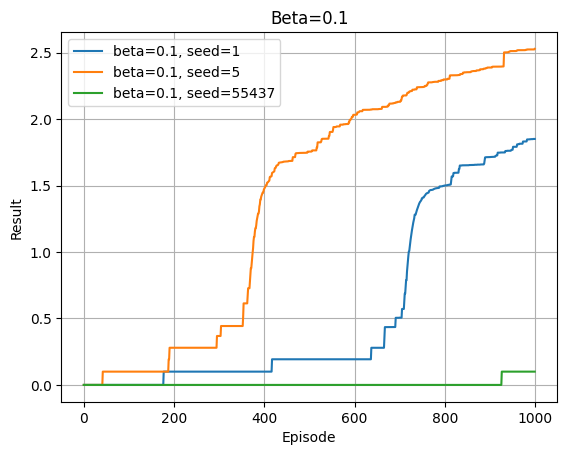

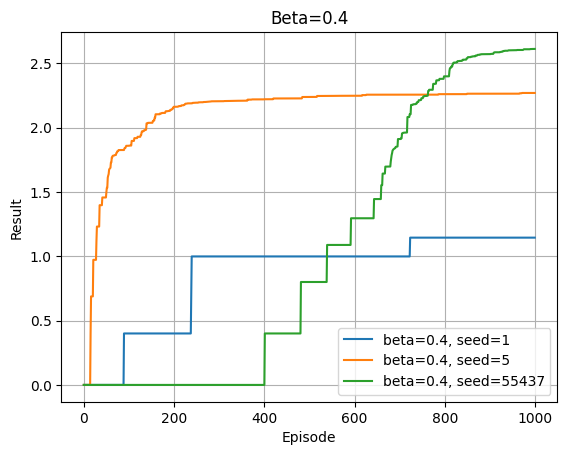

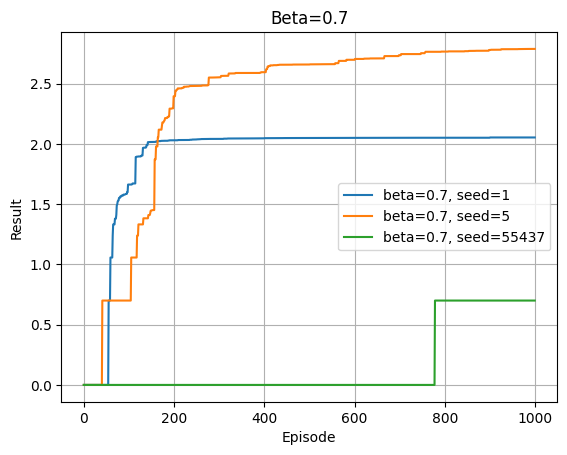

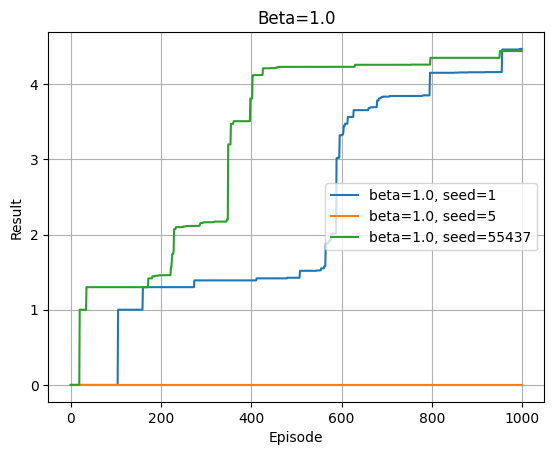

In [10]:
betas = range(1,11,3)
for i, beta in enumerate(betas):
    plt.figure()
    for seed in random_seeds:
        result,treasures = run(episodes, t_max, gamma_default, beta / 10, map_size, epsilon_default, seed, is_slippery, render)
        plt.plot(range(episodes), result, label=f'beta={beta/10}, seed={seed}')
    plt.legend()
    plt.title(f'Beta={beta/10}')
    plt.xlabel('Episode')
    plt.ylabel('Result')
    plt.grid(True)
    plt.show()

### Wpływ współczynnika dyskontowania $\gamma$

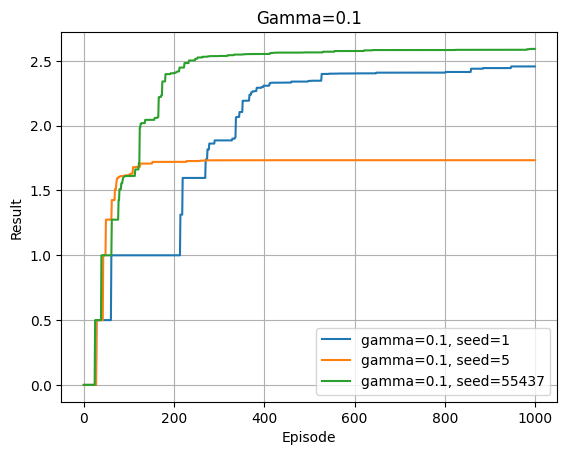

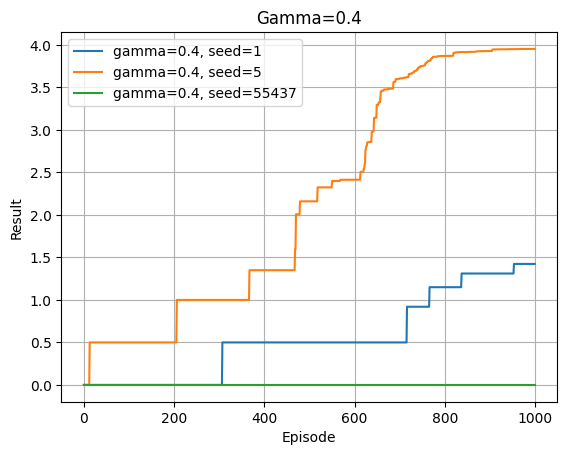

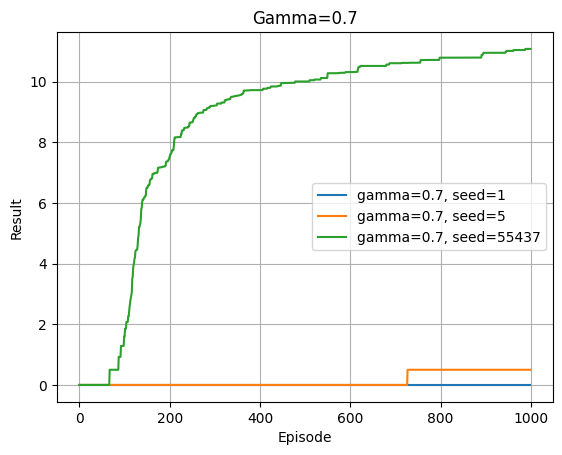

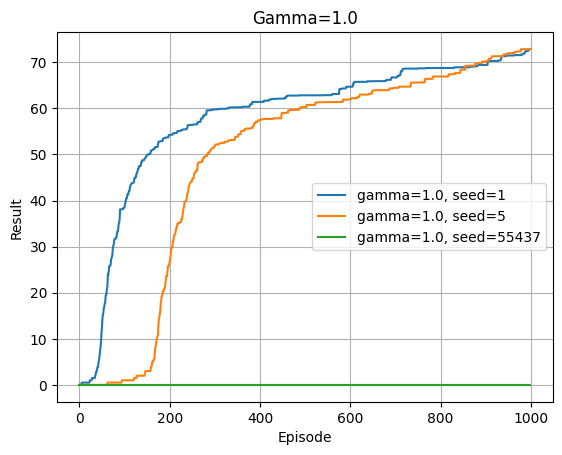

In [11]:
gammas = range(1,11,3)
for i, gamma in enumerate(gammas):
    plt.figure()
    for seed in random_seeds:
        result,treasures = run(episodes, t_max, gamma / 10, beta_default, map_size, epsilon_default, seed, is_slippery, render)
        plt.plot(range(episodes), result, label=f'gamma={gamma/10}, seed={seed}')
    plt.legend()
    plt.title(f'Gamma={gamma/10}')
    plt.xlabel('Episode')
    plt.ylabel('Result')
    plt.grid(True)
    plt.show()

### Wpływ współczynnika wyboru strategii $\epsilon$

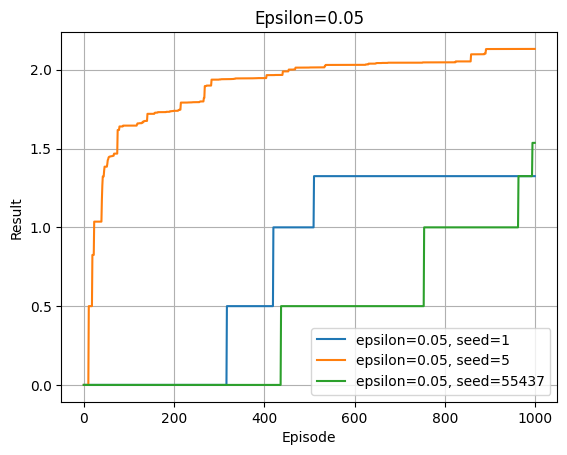

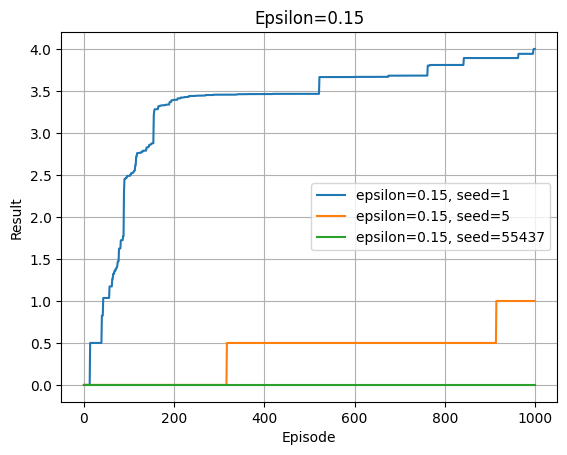

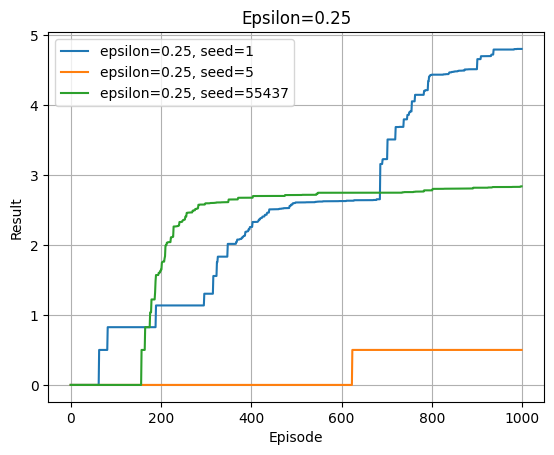

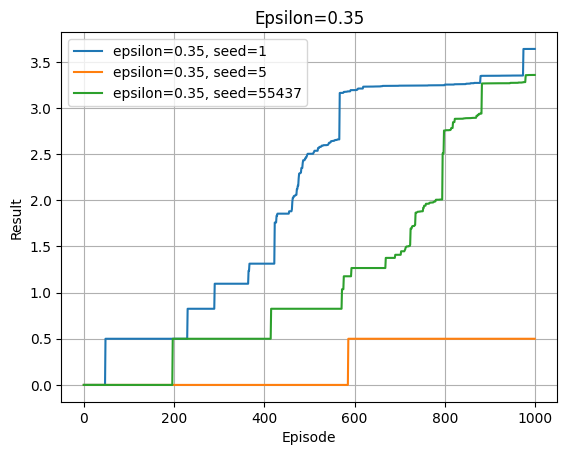

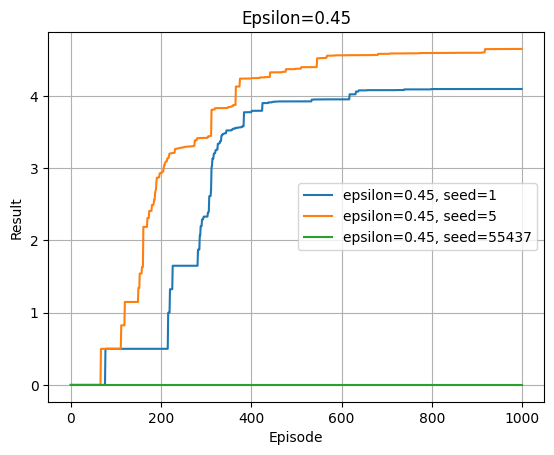

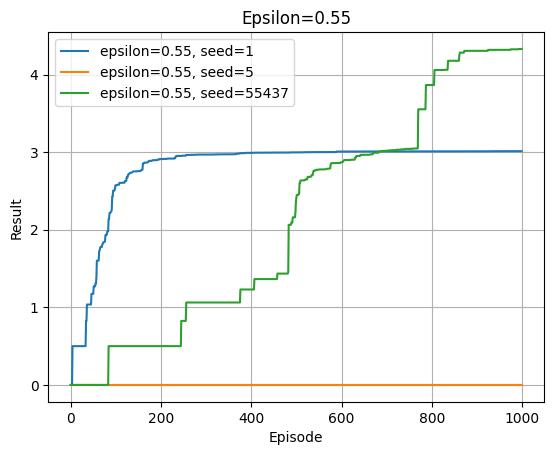

In [13]:
epsilons = range(5, 56,10)
for i, epsilon in enumerate(epsilons):
    plt.figure()
    for seed in random_seeds:
        result,treasures = run(episodes, t_max, gamma_default, beta_default, map_size, epsilon / 100, seed, is_slippery, render)
        plt.plot(range(episodes), result, label=f'epsilon={epsilon/100}, seed={seed}')
    plt.legend()
    plt.title(f'Epsilon={epsilon/100}')
    plt.xlabel('Episode')
    plt.ylabel('Result')
    plt.grid(True)
    plt.show()